# Lab 11: Grid Localization using Bayes Filter (Real Robot)

### <span style="color:rgb(0,150,0)">It is recommended that you close any heavy-duty applications running on your system while working on this lab.</span>

### <span style="color:rgb(0,150,0)">The notebook only provides skeleton code for you to integrate the Localization class with the Real Robot.</span>

<hr>

In [2]:
%load_ext autoreload
%autoreload 2

import traceback
from notebook_utils import *
from Traj import *
import asyncio
import pathlib
import os
from utils import load_config_params
from localization_extras import Localization

# The imports below will only work if you copied the required ble-related python files 
# into the notebooks directory
from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import numpy as np

from matplotlib import pyplot as plt
import random
import numpy as np

# Setup Logger
LOG = get_logger('demo_notebook.log')
LOG.propagate = False

# Init GUI and Commander
gui = GET_GUI()
cmdr = gui.launcher.commander

2023-05-17 02:16:50,394 | INFO     |: Logger demo_notebook.log initialized.


In [3]:
# Start the plotter
START_PLOTTER()

# The RealRobot class
Define the RealRobot class in the code cell below, based on the documentation and your real robot communication protocol. <br>
This class is used by the **Localization** class to communicate with the real robot. <br>
More specifically, the **Localization** class utilizes the **RealRobot's** member function **perform_observation_loop()** to get the 18 sensor readings and store them in its member variable **obs_range_data**, which is then utilized in the update step.

In [197]:
class RealRobot():
    """A class to interact with the real robot
    """
    def __init__(self, commander, ble):
        # Load world config
        self.world_config = os.path.join(str(pathlib.Path(os.getcwd()).parent), "config", "world.yaml")
        
        self.config_params = load_config_params(self.world_config)
        
        # Commander to commuincate with the Plotter process
        # Used by the Localization module to plot odom and belief
        self.cmdr = commander

        # ArtemisBLEController to communicate with the Robot
        self.ble = ble

    def get_pose(self):
        """Get robot pose based on odometry
        
        Returns:
            current_odom -- Odometry Pose (meters, meters, degrees)
        """
        
        
        raise NotImplementedError("get_pose is not implemented")
        

    def perform_observation_loop(self, rot_vel=120):
        """Perform the observation loop behavior on the real robot, where the robot does  
        a 360 degree turn in place while collecting equidistant (in the angular space) sensor
        readings, with the first sensor reading taken at the robot's current heading. 
        The number of sensor readings depends on "observations_count"(=18) defined in world.yaml.
        
        Keyword arguments:
            rot_vel -- (Optional) Angular Velocity for loop (degrees/second)
                        Do not remove this parameter from the function definition, even if you don't use it.
        Returns:
            sensor_ranges   -- A column numpy array of the range values (meters)
            sensor_bearings -- A column numpy array of the bearings at which the sensor readings were taken (degrees)
                               The bearing values are not used in the Localization module, so you may return a empty numpy array
        """
        
        # import numpy as np
        # with open('readings.txt') as f:
        #     lines = f.readlines()

#         strDist = lines[0].split("|")
#         intDist = np.array([eval(pos) for pos in strDist])[np.newaxis]
#         print(intDist.T)
        
        rawVals = np.array([1.444, 1.634, 1.264, 1.14, 1.128, 1.274, 1.546, 1.534, 1.412, 0.924, 3.472, 0.712, 4.444, 1.504, 1.52, 1.66, 1.78, 1.36])[np.newaxis]           
        print(rawVals)

#         with open('bearings.txt') as f:
#             lines = f.readlines()
            
        fixedYaw = []
        for i in range(0, 360, 20):
            fixedYaw.append(0)
            
        fixedYaw = np.array(fixedYaw)[np.newaxis]
        
        print(fixedYaw)
        print(len(fixedYaw))

        
        # strBear = lines[0].split("|")
        # intBear = np.array([eval(pos) for pos in strBear])[np.newaxis]
        # #print(intBear.T)
        
        
        return rawVals.T, fixedYaw.T
        
        #raise NotImplementedError("perform_observation_loop is not implemented")


In [27]:
import numpy as np
with open('readings.txt') as f:
    lines = f.readlines()

strDist = lines[0].split("|")
intDist =[eval(pos) for pos in strDist[:-1]]

print(intDist)

[0.476, 0.527, 0.33, 0.291, 0.279, 0.352, 0.491, 0.819, 0.2249, 0.2379, 0.2788, 0.694, 0.58, 0.2162, 0.1205, 0.627, 0.478, 0.441, 0.48]


[1.444, 1.634, 1.264, 1.14, 1.128, 1.274, 1.546, 1.534, 1.412, 0.924, 3.472, 0.712, 4.444, 1.504, 1.52, 1.66, 1.78, 1.36]


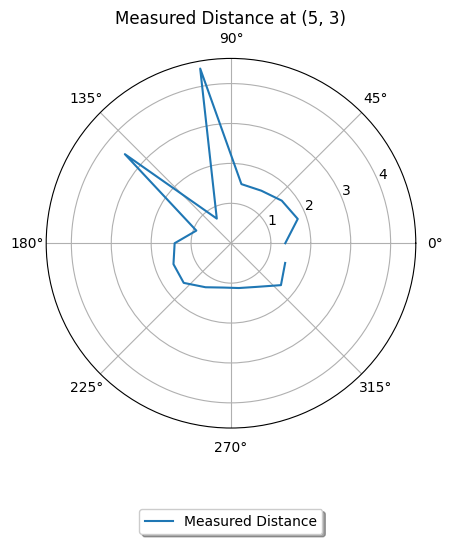

In [195]:
fixedYaw = []
for i in range(0, 360, 20):
    fixedYaw.append(i)

printDist = [0.722, 0.817, 0.632, 0.57, 0.564, 0.637, 0.773, 0.767, 0.706, 0.462, 1.736, 0.356, 2.222, 0.752, 0.76, 0.83, 0.89, 0.68]

for i in range(len(printDist)):
    printDist[i] = 2* printDist[i]
    
print(printDist)

outD = (printDist.reverse())



plt.polar(np.deg2rad(fixedYaw), printDist, label = "Measured Distance")

plt.title("Measured Distance at (5, 3)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)

In [13]:
# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2023-05-17 02:18:36,598 | INFO     |: Looking for Artemis Nano Peripheral Device: C0:83:D5:66:86:3C
2023-05-17 02:18:39,139 | INFO     |: Connected to C0:83:D5:66:86:3C


/Users/kunalgupta/Desktop/CORNELL/SP23/Fast Robots/Fast_Robots_Portfolio/lab11/FastRobots-sim-release-release-mirror/notebooks/base_ble.py:87: FutureWarning: This method will be removed future version, pass the callback to the BleakClient constructor instead.
  self.client.set_disconnected_callback(self.disconnect_handler)


In [198]:
# Initialize RealRobot with a Commander object to communicate with the plotter process
# and the ArtemisBLEController object to communicate with the real robot
robot = RealRobot(cmdr, ble)

# Initialize mapper
# Requires a VirtualRobot object as a parameter
mapper = Mapper(robot)

# Initialize your BaseLocalization object
# Requires a RealRobot object and a Mapper object as parameters
loc = Localization(robot, mapper)

## Plot Map
cmdr.plot_map()

2023-05-17 03:56:56,841 | INFO     |:  | Number of observations per grid cell: 18
2023-05-17 03:56:56,842 | INFO     |:  | Precaching Views...
2023-05-17 03:56:58,101 | INFO     |:  | Precaching Time: 1.259 secs
2023-05-17 03:56:58,102 | INFO     |: Initializing beliefs with a Uniform Distribution
2023-05-17 03:56:58,102 | INFO     |: Uniform Belief with each cell value: 0.00051440329218107


# Run an update step of the Bayes Filter

In [199]:
# Reset Plots
cmdr.reset_plotter()

loc.init_grid_beliefs()

# Get Observation Data by executing a 360 degree rotation motion
loc.get_observation_data()

# Run Update Step
loc.update_step()
loc.plot_update_step_data(plot_data=True)

# Plot Odom and GT
# current_odom, current_gt = robot.get_pose()
# cmdr.plot_gt(current_gt[0], current_gt[1])
# cmdr.plot_odom(current_odom[0], current_odom[1])

2023-05-17 03:56:59,467 | INFO     |: Initializing beliefs with a Uniform Distribution
2023-05-17 03:56:59,468 | INFO     |: Uniform Belief with each cell value: 0.00051440329218107
[[1.444 1.634 1.264 1.14  1.128 1.274 1.546 1.534 1.412 0.924 3.472 0.712
  4.444 1.504 1.52  1.66  1.78  1.36 ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
1
2023-05-17 03:56:59,468 | INFO     |: Update Step
2023-05-17 03:56:59,470 | INFO     |:      | Update Time: 0.001 secs
2023-05-17 03:56:59,470 | INFO     |: Bel index     : (2, 3, 16) with prob = 0.9999999
2023-05-17 03:56:59,470 | INFO     |: Bel_bar prob at index = 0.00051440329218107
2023-05-17 03:56:59,471 | INFO     |: Belief        : (-0.914, -0.305, 150.000)


Traceback (most recent call last):
  File "/Users/kunalgupta/Desktop/CORNELL/SP23/Fast Robots/Fast_Robots_Portfolio/lab11/FastRobots-sim-release-release-mirror/src/plotter.py", line 263, in keyPressEvent
    if event.key() == Qt.Key_Escape:
AttributeError: type object 'Qt' has no attribute 'Key_Escape'
Traceback (most recent call last):
  File "/Users/kunalgupta/Desktop/CORNELL/SP23/Fast Robots/Fast_Robots_Portfolio/lab11/FastRobots-sim-release-release-mirror/src/plotter.py", line 263, in keyPressEvent
    if event.key() == Qt.Key_Escape:
AttributeError: type object 'Qt' has no attribute 'Key_Escape'
Traceback (most recent call last):
  File "/Users/kunalgupta/Desktop/CORNELL/SP23/Fast Robots/Fast_Robots_Portfolio/lab11/FastRobots-sim-release-release-mirror/src/plotter.py", line 263, in keyPressEvent
    if event.key() == Qt.Key_Escape:
AttributeError: type object 'Qt' has no attribute 'Key_Escape'
Traceback (most recent call last):
  File "/Users/kunalgupta/Desktop/CORNELL/SP23/Fast R

2023-05-17 04:01:23,483 | INFO     |: Disconnected from 9FB4D05A-FE1D-DF59-F920-0B9FD132922D
